In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import *
import astropy
from astropy import constants as ac
#from astroquery.mast import Observations
import lightkurve
import celerite
from celerite import terms
from scipy.optimize import minimize
from astropy.io import fits
from astropy.table import Table
import emcee
import stella

### Using Stella to compare with Jim's flare sample for Gj1243
http://adina.feinste.in/stella/getting_started/shortest_demo.html#1.2-Using-the-Models

In [2]:
import eleanor

In [3]:
import os, sys
#sys.path.insert(1, '/Users/arcticfox/Documents/GitHub/stella/')
#/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/stella/
from tqdm import tqdm_notebook

In [ ]:
#sys.path

In [4]:
ds = stella.DownloadSets()
ds.download_models()

Models have already been downloaded to ~/.stella/models


In [ ]:
ds.models

In [5]:
ds.models[0]

'/Users/lupitatovar/.stella/models/hlsp_stella_tess_ensemblemodel_s004_tess_v0.1.0_cnn.h5'

Initialize the class

In [6]:
OUT_DIR = '/Users/lupitatovar/local_flares/stella/results'

In [7]:
cnn = stella.ConvNN(output_dir=OUT_DIR)

Can only use stella.ConvNN.predict().


Importing in example light curve (following stella docs) 
[low mass star M0]

/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  after removing the cwd from sys.path.
/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/lightkurve/search.py:352: LightkurveWarning: Warning: 3 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  LightkurveWarning,
/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  """


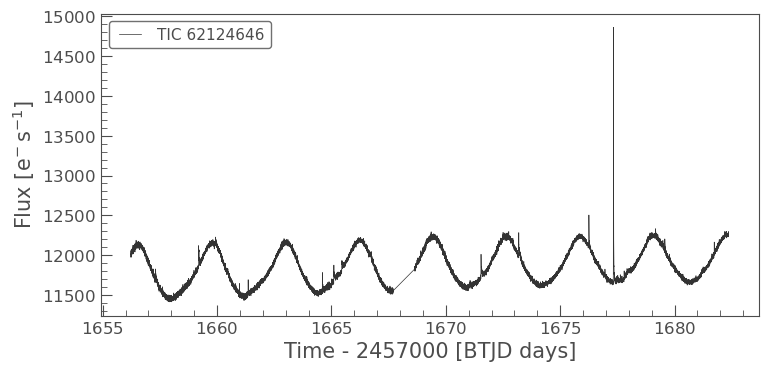

In [8]:
#### create a lightkurve for a two minute target here for the example
from lightkurve.search import search_lightcurvefile

lc = search_lightcurvefile(target='tic62124646', mission='TESS', sector=13)
lc = lc.download().PDCSAP_FLUX.remove_nans()
lc.plot();

In [ ]:
lc.time.btjd

Now use the model we saved to predict flares on the light curve

In [9]:
cnn.predict(modelname=ds.models[0],
            times=lc.time.btjd,
            fluxes=lc.flux,
            errs=lc.flux_err)
single_pred = cnn.predictions[0]

100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


In [10]:
#overview of the model that is being used
cnn.model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 200, 16)           64        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 100, 16)           0         
_________________________________________________________________
dropout (Dropout)            (None, 100, 16)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 100, 64)           3136      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 50, 64)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 3200)              0

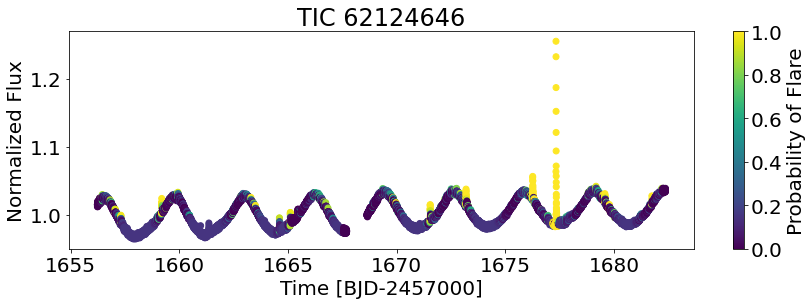

In [11]:
plt.rcParams['font.size'] = 20
plt.figure(figsize=(14,4))
plt.scatter(cnn.predict_time[0], cnn.predict_flux[0],
            c=single_pred, vmin=0, vmax=1)
plt.colorbar(label='Probability of Flare')
plt.xlabel('Time [BJD-2457000]')
plt.ylabel('Normalized Flux')
plt.title('TIC {}'.format(lc.targetid));

Now you can loop through all 10 models provided and average over the predictions from each model. This is called ensembling and can provide more accurate predictions than using a single model.

In [12]:
len(ds.models)

10

In [13]:
#ensembling
preds = np.zeros((len(ds.models),len(cnn.predictions[0])))

for i, model in enumerate(ds.models):
    cnn.predict(modelname=ds.models[0],
                times=lc.time.btjd,
                fluxes=lc.flux,
                errs=lc.flux_err)
    preds[i] = cnn.predictions[0]

avg_pred = np.nanmedian(preds, axis=0)

100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


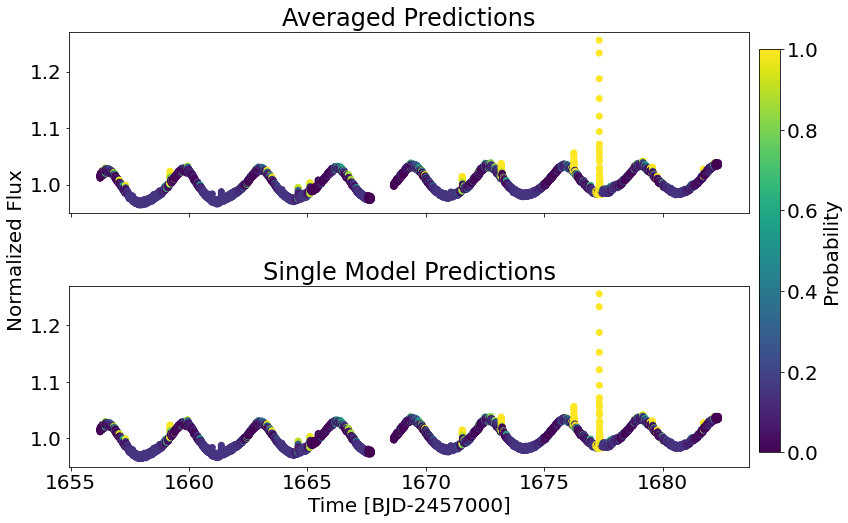

In [14]:
fig, (ax1, ax2) = plt.subplots(figsize=(14,8), nrows=2,
                               sharex=True, sharey=True)
im = ax1.scatter(cnn.predict_time[0], cnn.predict_flux[0],
            c=avg_pred, vmin=0, vmax=1)
ax2.scatter(cnn.predict_time[0], cnn.predict_flux[0],
            c=single_pred, vmin=0, vmax=1)
ax2.set_xlabel('Time [BJD-2457000]')
ax2.set_ylabel('Normalized Flux', y=1.2)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.81, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax, label='Probability')


ax1.set_title('Averaged Predictions')
ax2.set_title('Single Model Predictions')

plt.subplots_adjust(hspace=0.4);

(1662.0, 1664.0)

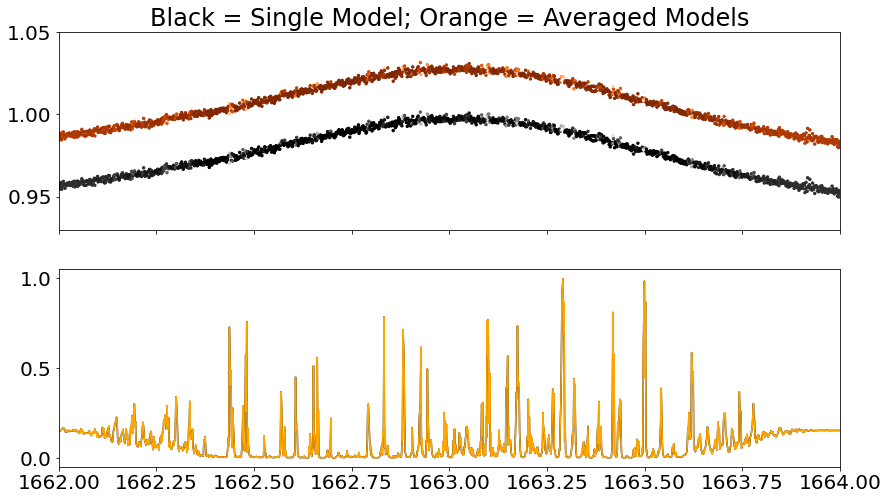

In [17]:
#zooming in to see differences
fig, (ax1, ax2) = plt.subplots(figsize=(14,8), nrows=2,
                               sharex=True)
ax1.scatter(cnn.predict_time[0], cnn.predict_flux[0],
            c=avg_pred, vmin=0, vmax=1, cmap='Oranges_r', s=6)
ax1.scatter(cnn.predict_time[0], cnn.predict_flux[0]-0.03,
            c=single_pred, vmin=0, vmax=1, cmap='Greys_r', s=6)
ax1.set_ylim(0.93,1.05)
ax2.plot(cnn.predict_time[0], single_pred, 'k')
ax2.plot(cnn.predict_time[0], avg_pred, 'orange')
ax1.set_title('Black = Single Model; Orange = Averaged Models')

plt.xlim(1662,1664)

### Importing in lightcurve for GJ1243

In [18]:
from lightkurve import search_lightcurvefile
from lightkurve import search_targetpixelfile
#target = '273589987'
target='9726699'
gj1243_tess = search_lightcurvefile(target,cadence='short',mission='TESS').download_all()

/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  """


In [19]:
tess_collection=gj1243_tess[-2:]
#tess_collection

In [86]:
s14 = tess_collection[0].PDCSAP_FLUX.remove_nans()
s15 = tess_collection[1].PDCSAP_FLUX.remove_nans()

/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  """Entry point for launching an IPython kernel.
/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  


In [20]:
gj1243_tesslc = tess_collection[0].PDCSAP_FLUX.remove_nans()

for q in range(1,len(tess_collection)):
    try:
        gj1243_tesslc = gj1243_tesslc.append(tess_collection[q].PDCSAP_FLUX).remove_nans()
    except:
            print(q)

/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  """Entry point for launching an IPython kernel.
/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  """


<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

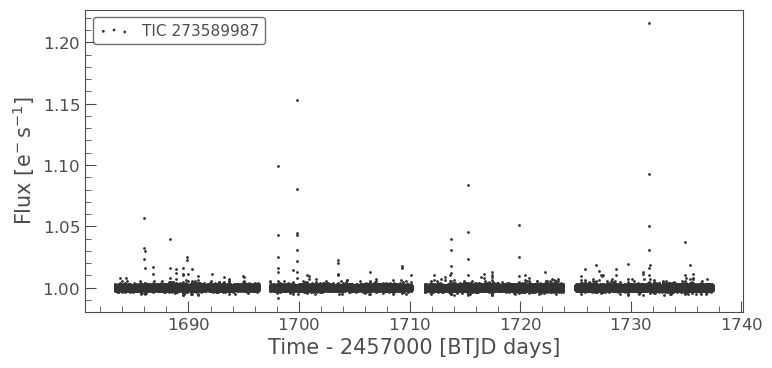

In [21]:
flat_lc = gj1243_tesslc.flatten(window_length=11)
flat_lc.scatter()
#gj1243_tesslc.scatter()

In [ ]:
flat_lc.time

In [22]:
OUT_DIR2 = '/Users/lupitatovar/local_flares/stella/results'
cnn2 = stella.ConvNN(output_dir=OUT_DIR2)

Can only use stella.ConvNN.predict().


In [23]:
cnn2.predict(modelname=ds.models[0],
            times=flat_lc.time.btjd,
            fluxes=flat_lc.flux,
            errs=flat_lc.flux_err)
single_pred_2 = cnn2.predictions[0]

100%|██████████| 1/1 [00:02<00:00,  2.62s/it]


In [24]:
cnn2.model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 200, 16)           64        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 100, 16)           0         
_________________________________________________________________
dropout (Dropout)            (None, 100, 16)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 100, 64)           3136      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 50, 64)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 3200)              0

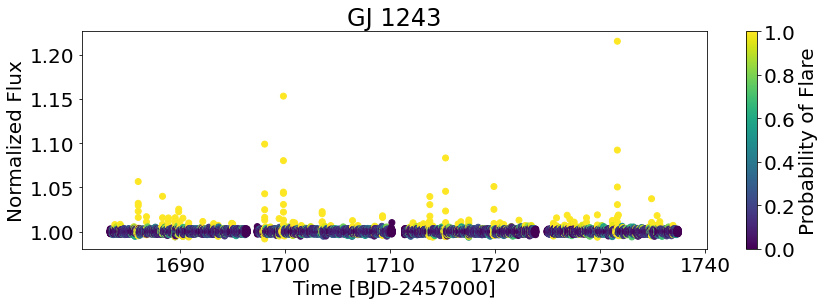

In [25]:
plt.figure(figsize=(14,4))
plt.scatter(cnn2.predict_time[0], cnn2.predict_flux[0],
            c=single_pred_2, vmin=0, vmax=1)
plt.colorbar(label='Probability of Flare')
plt.xlabel('Time [BJD-2457000]')
plt.ylabel('Normalized Flux')
plt.title('GJ 1243');

In [26]:
#ensembling
preds2 = np.zeros((len(ds.models),len(cnn2.predictions[0])))

for i, model in enumerate(ds.models):
    cnn2.predict(modelname=ds.models[0],
                times=flat_lc.time.btjd,
                fluxes=flat_lc.flux,
                errs=flat_lc.flux_err)
    preds2[i] = cnn2.predictions[0]

avg_pred = np.nanmedian(preds2, axis=0)

100%|██████████| 1/1 [00:02<00:00,  2.69s/it]


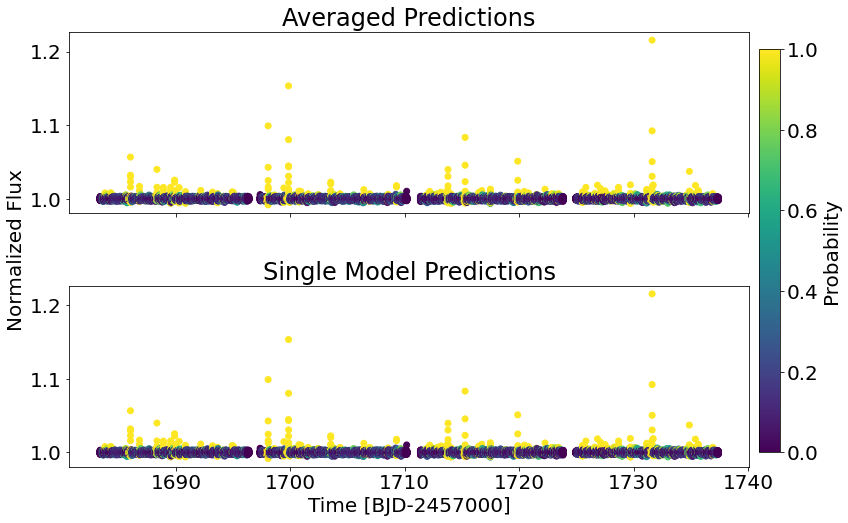

In [27]:
fig, (ax1, ax2) = plt.subplots(figsize=(14,8), nrows=2,
                               sharex=True, sharey=True)
im = ax1.scatter(cnn2.predict_time[0], cnn2.predict_flux[0],
            c=avg_pred, vmin=0, vmax=1)
ax2.scatter(cnn2.predict_time[0], cnn2.predict_flux[0],
            c=single_pred_2, vmin=0, vmax=1)
ax2.set_xlabel('Time [BJD-2457000]')
ax2.set_ylabel('Normalized Flux', y=1.2)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.81, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax, label='Probability')


ax1.set_title('Averaged Predictions')
ax2.set_title('Single Model Predictions')

plt.subplots_adjust(hspace=0.4);

(1733.0, 1735.0)

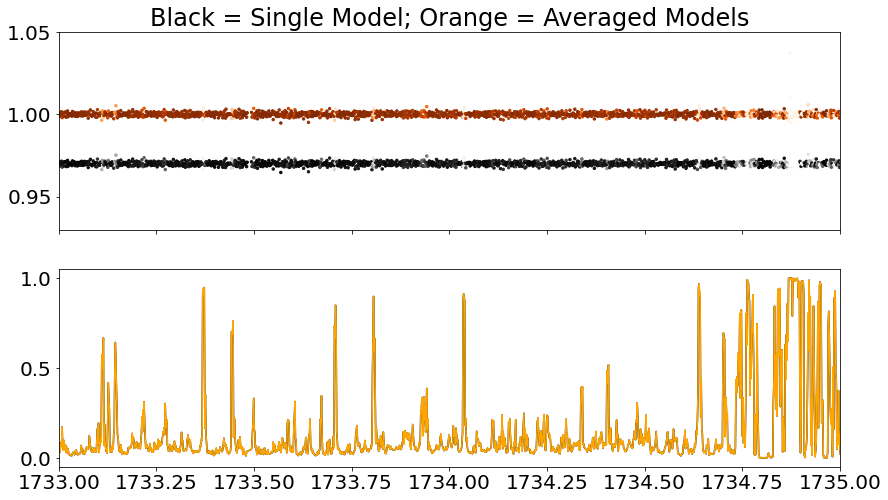

In [29]:
#zooming in to see differences
fig, (ax1, ax2) = plt.subplots(figsize=(14,8), nrows=2,
                               sharex=True)
ax1.scatter(cnn2.predict_time[0], cnn2.predict_flux[0],
            c=avg_pred, vmin=0, vmax=1, cmap='Oranges_r', s=6)
ax1.scatter(cnn2.predict_time[0], cnn2.predict_flux[0]-0.03,
            c=single_pred_2, vmin=0, vmax=1, cmap='Greys_r', s=6)
ax1.set_ylim(0.93,1.05)
ax2.plot(cnn2.predict_time[0], single_pred_2, 'k')
ax2.plot(cnn2.predict_time[0], avg_pred, 'orange')
ax1.set_title('Black = Single Model; Orange = Averaged Models')

#plt.xlim(1699,1705)
plt.xlim(1733,1735)

### Measuring Rotation Period : http://adina.feinste.in/stella/getting_started/other_features.html
(not quite right need to revisit)

In [87]:
s14.time

<Time object: scale='tdb' format='btjd' value=[1683.35617589 1683.3575648  1683.35895371 ... 1710.20359189 1710.20498078
 1710.20636967]>

In [89]:
mProt_14 = stella.MeasureProt([target], [s14.time.btjd], [s14.flux], [s14.flux_err])
mProt_15 = stella.MeasureProt([target], [s15.time.btjd], [s15.flux], [s15.flux_err])

In [90]:
mProt_14.run_LS()
mProt_15.run_LS()

Finding most likely periods: 100%|██████████| 1/1 [00:00<00:00, 10.20it/s]


In [91]:
mProt_14.LS_results

Target_ID,period_days,secondary_period_days,gauss_width,max_power,secondary_max_power,orbit_flag,oflag1,oflag2,Flags,avg_period_days
str7,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64
9726699,0.5926969380594846,0.5924234938039095,0.009974527032471626,0.5408617922290281,0.09906267135174686,0.0,0.0,0.0,0,0.5926969380594846


In [92]:
mProt_15.LS_results

Target_ID,period_days,secondary_period_days,gauss_width,max_power,secondary_max_power,orbit_flag,oflag1,oflag2,Flags,avg_period_days
str7,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64
9726699,0.5935048466649321,0.5933696087768825,0.010254086714809344,0.6672466355818547,0.1227854042445978,0.0,0.0,0.0,0,0.5935048466649321


<AxesSubplot:xlabel='Phase [JD]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

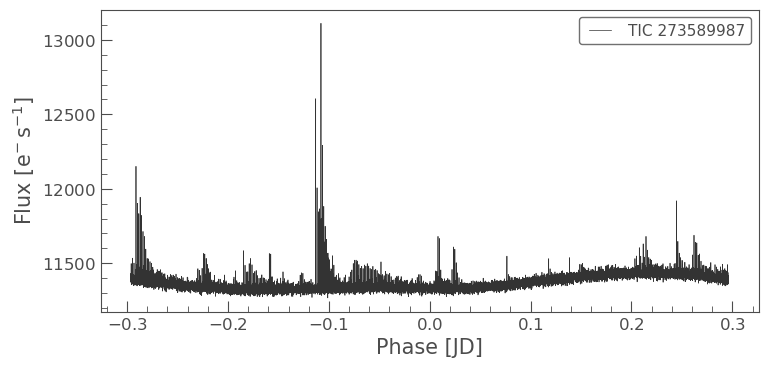

In [93]:
s14.fold(mProt_14.LS_results['avg_period_days'].data[0]).plot()

<AxesSubplot:xlabel='Phase [JD]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

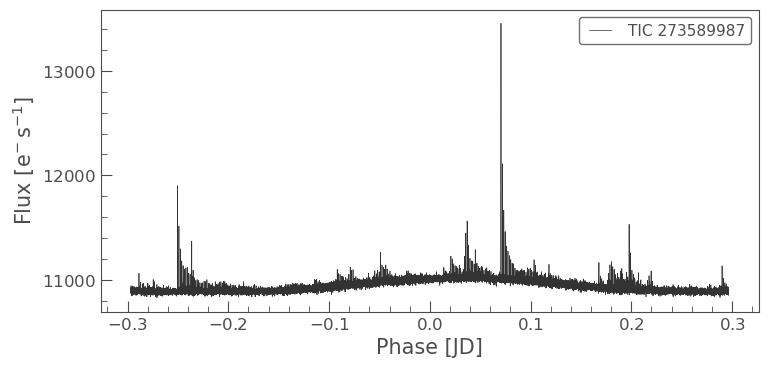

In [94]:
s15.fold(mProt_15.LS_results['avg_period_days'].data[0]).plot()

### Fitting Flares with Stella

In [44]:
MODEL_DIR = '/Users/lupitatovar/.stella/models'
MODEL = [os.path.join(MODEL_DIR,i) for i in
          os.listdir(MODEL_DIR) if i.endswith('.h5')][0]

In [45]:
cnn_fit = stella.ConvNN(output_dir='.')
cnn_fit.predict(modelname=MODEL,
            times=flat_lc.time.btjd,
            fluxes=flat_lc.flux,
            errs=flat_lc.flux_err)

  0%|          | 0/1 [00:00<?, ?it/s]

Can only use stella.ConvNN.predict().


100%|██████████| 1/1 [00:02<00:00,  2.67s/it]


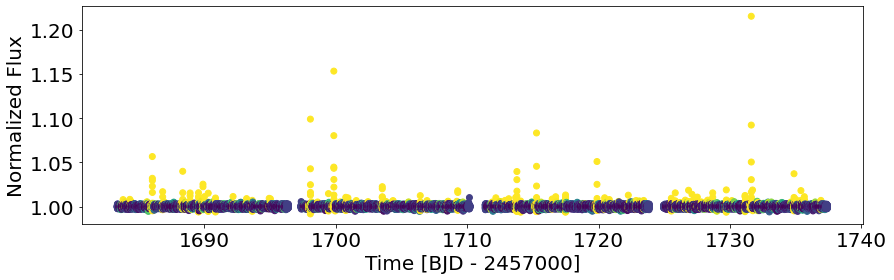

In [47]:
plt.figure(figsize=(14,4))
plt.scatter(cnn_fit.predict_time[0], cnn_fit.predict_flux[0], c=cnn_fit.predictions[0], vmin=0, vmax=1)
plt.xlabel('Time [BJD - 2457000]')
plt.ylabel('Normalized Flux');

In [59]:
# fitting the flares
ff = stella.FitFlares(id=[target],
                      time=[flat_lc.time.btjd],
                      flux=[flat_lc.flux.value],
                      flux_err=[flat_lc.flux_err.value],
                      predictions=[cnn_fit.predictions[0]])

In [58]:
flat_lc.flux.value

array([0.99940654, 1.00090786, 0.99979793, ..., 0.99984561, 0.99830835,
       1.00132053])

In [60]:
ff.identify_flare_peaks(threshold=0.5)

ff.flare_table

Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(results)
Finding & Fitting Flares: 100%|██████████| 1/1 [00:01<00:00,  1.46s/it]


Target_ID,tpeak,amp,ed_s,rise,fall,prob
float64,float64,float64,float64,float64,float64,float64
9726699.0,1683.8034041885226,1.007841070530858,1.3591946056789421,0.0001,0.0011567613173870915,0.9998941421508789
9726699.0,1684.0756299734162,1.0031135898054817,0.5103495111171293,0.0001,0.0009994563959194879,0.6323788166046143
9726699.0,1685.9381533558415,1.0022968261076264,0.3770489607968726,0.0001,0.0010382422221191943,0.9900827407836914
9726699.0,1686.028432240426,1.0569463578389093,20.253854810133767,0.0001,0.003405635177730015,1.0
9726699.0,1686.028432240426,1.0569463578389093,20.253854810133767,0.0001,0.003405635177730015,1.0
9726699.0,1686.028432240426,1.0569463578389093,20.253854810133767,0.0001,0.003405635177730015,1.0
9726699.0,1686.028432240426,1.0569463578389093,20.253854810133767,0.0001,0.003405635177730015,1.0
9726699.0,1686.815941809787,1.0167357073927867,4.039117641551494,0.0001,0.0019571248100425857,1.0
9726699.0,1686.815941809787,1.0167357073927867,4.039117641551494,0.0001,0.0019571248100425857,1.0


In [82]:
flare = [ff.flare_table[ff.flare_table['prob'] == 1.0]]
print((flare))
#74 instances where probability of a flare = 1 

[<Table length=74>
Target_ID       tpeak        ...          fall           prob 
 float64       float64       ...        float64        float64
--------- ------------------ ... --------------------- -------
9726699.0  1686.028432240426 ...  0.003405635177730015     1.0
9726699.0  1686.028432240426 ...  0.003405635177730015     1.0
9726699.0  1686.028432240426 ...  0.003405635177730015     1.0
9726699.0  1686.028432240426 ...  0.003405635177730015     1.0
9726699.0  1686.815941809787 ... 0.0019571248100425857     1.0
9726699.0  1686.815941809787 ... 0.0019571248100425857     1.0
9726699.0  1686.815941809787 ... 0.0019571248100425857     1.0
9726699.0  1686.815941809787 ... 0.0019571248100425857     1.0
9726699.0  1686.815941809787 ... 0.0019571248100425857     1.0
9726699.0 1688.3423488276135 ... 0.0016661647167149456     1.0
      ...                ... ...                   ...     ...
9726699.0  1731.714490795848 ...  0.001424430424868002     1.0
9726699.0  1731.714490795848 ...  0.

Marking the flares

(0.99, 1.02)

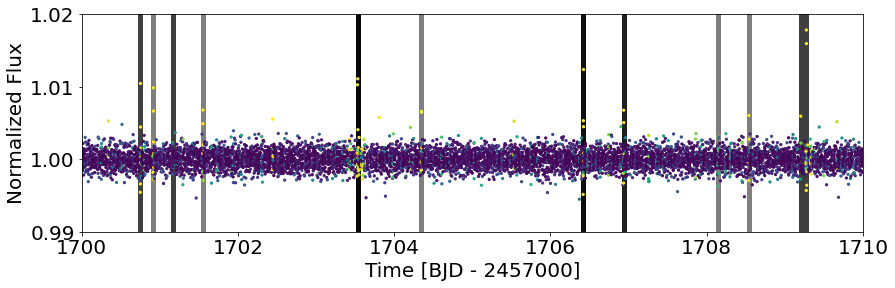

In [78]:
plt.figure(figsize=(14,4))
plt.scatter(ff.time[0], ff.flux[0], c=cnn_fit.predictions[0], s=5)

for tpeak in ff.flare_table['tpeak']:
    plt.vlines(tpeak, 0,2, color='k', alpha=0.5, linewidth=5, zorder=0)

plt.ylim(0.94,1.3)
plt.xlabel('Time [BJD - 2457000]')
plt.ylabel('Normalized Flux');
plt.xlim(1700,1710)
plt.ylim(0.99,1.02)

### Per sector flares

Sector 14 Flares

In [95]:
cnn_fit_14 = stella.ConvNN(output_dir='.')
cnn_fit_14.predict(modelname=MODEL,
            times=s14.time.btjd,
            fluxes=s14.flux,
            errs=s14.flux_err)

Can only use stella.ConvNN.predict().


100%|██████████| 1/1 [00:01<00:00,  1.51s/it]


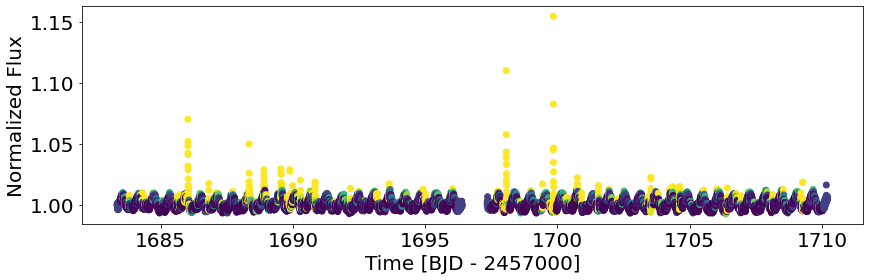

In [96]:
plt.figure(figsize=(14,4))
plt.scatter(cnn_fit_14.predict_time[0], cnn_fit_14.predict_flux[0], c=cnn_fit_14.predictions[0], vmin=0, vmax=1)
plt.xlabel('Time [BJD - 2457000]')
plt.ylabel('Normalized Flux');

In [118]:
s14.targetid

273589987

In [119]:
target

'9726699'

In [128]:
cnn_fit_14.predictions[0]

array([0.18410772, 0.18410772, 0.18410772, ..., 0.18410772, 0.18410772,
       0.18410775], dtype=float32)

In [124]:
#S14
ff14 = stella.FitFlares(id=[s14.targetid],
                      time=[s14.time.btjd],
                      flux=[s14.flux.value],
                      flux_err=[s14.flux_err.value],
                      predictions=[cnn_fit_14.predictions[0]])

In [125]:
ff14.identify_flare_peaks(threshold=0.5)

ff14.flare_table

Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(results)
Finding & Fitting Flares: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


Target_ID,tpeak,amp,ed_s,rise,fall,prob
float64,float64,float64,float64,float64,float64,float64
9726699.0,1688.9881896712468,1.0062684847372938,7.292271459934418,0.01,0.003281357090428864,0.9973636269569397
9726699.0,1691.907667110957,1.007784118516363,15.57188215256548,0.01,0.01,0.6728654503822327


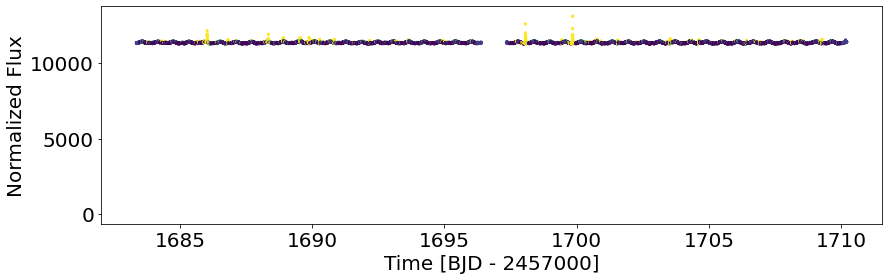

In [126]:
plt.figure(figsize=(14,4))
plt.scatter(ff14.time[0], ff14.flux[0], c=cnn_fit_14.predictions[0], s=5)

for tpeak in ff14.flare_table['tpeak']:
    plt.vlines(tpeak, 0,2, color='k', alpha=0.5, linewidth=5, zorder=0)

#plt.ylim(0.94,1.3)
plt.xlabel('Time [BJD - 2457000]')
plt.ylabel('Normalized Flux');


Sector 15 Flares

In [101]:
cnn_fit_15 = stella.ConvNN(output_dir='.')
cnn_fit_15.predict(modelname=MODEL,
            times=s15.time.btjd,
            fluxes=s15.flux,
            errs=s15.flux_err)

  0%|          | 0/1 [00:00<?, ?it/s]

Can only use stella.ConvNN.predict().


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


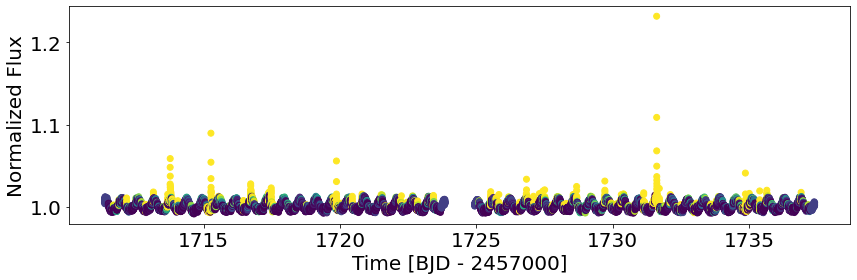

In [102]:
plt.figure(figsize=(14,4))
plt.scatter(cnn_fit_15.predict_time[0], cnn_fit_15.predict_flux[0], c=cnn_fit_15.predictions[0], vmin=0, vmax=1)
plt.xlabel('Time [BJD - 2457000]')
plt.ylabel('Normalized Flux');

In [103]:
#S15
# fitting the flares
ff15 = stella.FitFlares(id=[target],
                      time=[s15.time.btjd],
                      flux=[s15.flux.value],
                      flux_err=[s15.flux_err.value],
                      predictions=[cnn_fit_15.predictions[0]])

In [104]:
ff15.identify_flare_peaks(threshold=0.5)

ff15.flare_table

Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(results)
Finding & Fitting Flares: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


Target_ID,tpeak,amp,ed_s,rise,fall,prob
float64,float64,float64,float64,float64,float64,float64
9726699.0,1715.0146784611275,1.0088868340273893,19.222741316754984,0.01,0.01,0.6089034080505371
9726699.0,1720.9937987375217,1.0033935997034384,1.8696995845170956,0.0027736115789260525,0.007382030718647171,0.5593361258506775
9726699.0,1722.1382343236437,1.0068984044164186,14.006537023712397,0.01,0.01,0.5324165225028992
9726699.0,1729.878410834627,1.0027069423473092,2.768833068891916,0.0030138769078253682,0.008009886774558824,0.502739667892456
9726699.0,1735.1574873150992,1.009108431978765,20.217851350912035,0.01,0.01,0.7419126629829407
9726699.0,1735.1574873150992,1.009108431978765,20.217851350912035,0.01,0.01,0.7419126629829407
9726699.0,1736.3741339544035,1.0045353615246981,4.624553135596795,0.003018434114911729,0.008001853085827158,0.6687672138214111
9726699.0,1736.3741339544035,1.0045353615246981,4.624553135596795,0.003018434114911729,0.008001853085827158,0.6687672138214111


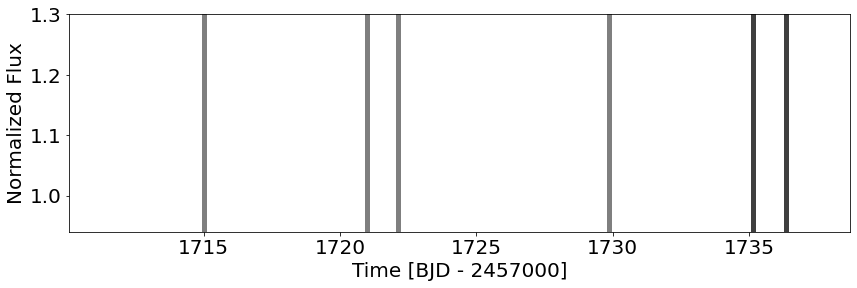

In [107]:
plt.figure(figsize=(14,4))
plt.scatter(ff15.time[0], ff15.flux[0], c=cnn_fit_15.predictions[0], s=5)

for tpeak in ff15.flare_table['tpeak']:
    plt.vlines(tpeak, 0,2, color='k', alpha=0.5, linewidth=5, zorder=0)

plt.ylim(0.94,1.3)
plt.xlabel('Time [BJD - 2457000]')
plt.ylabel('Normalized Flux');
